In [610]:
import numpy as np
import math
import sys
from scipy.integrate import quad
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.table import QTable
from astropy.table import Table, join, vstack, hstack
from astropy.table import Column

# open catalogues
M52 = fits.open('M52_Members.fits')
main_seq = fits.open('main_seq.fits')

# create tables 
M52_tab = Table(M52[1].data)
ms_tab = Table(main_seq[1].data)

N = len(ms_tab)

card_ratio = 0.7192 # slope of dereddening vector 
card = 3.1 # cardelli ratio 


In [612]:
# rename columns to help analysis
# for NGC cat
M52_tab.rename_column('Vmag', 'V')
M52_tab.rename_column('Verr', 'V_err')
M52_tab.rename_column('Berr', 'B_err')
M52_tab.rename_column('Uerr', 'U_err')

# for M52 cat
# M52_tab.rename_column('col6', 'V')
# M52_tab.rename_column('col7', 'V_err')
# M52_tab.rename_column('col9', 'B_err')
# M52_tab.rename_column('col11', 'U_err')
# M52_tab.rename_column('col12', 'B-V')
# M52_tab.rename_column('col13', 'U-B')

ms_tab.rename_column('col2', 'U-B')
ms_tab.rename_column('col3', 'B-V')

In [613]:
M52_tab

ID,RA,Dec,X,Y,V,V_err,Bmag,B_err,Umag,U_err,B-V,U-B,pmra,pmra_error,pmdec,pmdec_error
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32
132.0,351.0574734,61.7945144,1452.0502,460.099,15.3796,0.0798,16.1451,0.1191,16.6979,0.4899,0.7654999999999994,0.5528000000000013,-2.0066899564064817,0.022752097,-1.1705327724843213,0.021377759
137.0,351.1770126,61.7929052,1883.6274,475.24,15.0994,0.0696,15.9799,0.1101,16.3311,0.4142,0.8805000000000014,0.3511999999999986,-1.7584562649138935,0.021742484,-1.2414869290684258,0.020704474
188.0,351.295117,61.7693594,2309.4133,657.1417,15.9135,0.1031,16.8165,0.1637,16.8636,0.5272,0.9030000000000005,0.047100000000000364,-1.8636025603881132,0.029590739,-1.3099663907150492,0.02532734
201.0,350.8277322,61.7610946,619.6464,707.6782,14.2539,0.0467,14.9837,0.069,15.3152,0.2587,0.7298000000000009,0.33150000000000013,-2.010506070488098,0.01421905,-1.2548792165646532,0.013385017
249.0,351.0533506,61.741879,1434.0909,862.0598,14.9951,0.0663,15.9161,0.1069,16.3852,0.4243,0.9209999999999994,0.46910000000000096,-2.1069473927594293,0.03784155,-1.1854112908061594,0.035095297
261.0,351.5973789,61.7405273,3401.9268,879.0723,15.7421,0.095,16.51,0.1418,15.5039,0.2823,0.7679000000000009,-1.0061000000000018,-1.9435836620897886,0.024805441,-1.1544232895364903,0.02043835
280.0,351.3755942,61.731579,2599.4746,946.6888,14.885,0.0628,15.555,0.0902,15.9558,0.3479,0.6699999999999999,0.40080000000000027,-2.0036891107638057,0.023700006,-1.1336259133543856,0.02015669
304.0,351.2432083,61.7219721,2120.1089,1018.3303,14.9353,0.0645,15.7324,0.0981,15.795,0.323,0.7971000000000004,0.06259999999999977,-2.051847296346958,0.020136353,-1.055515044634115,0.017630676
310.0,351.0558943,61.7206124,1442.057,1024.5804,15.2431,0.0752,16.1265,0.1184,16.6633,0.4818,0.8834,0.5367999999999995,-2.4229293885640515,0.024138188,-1.0457233864027025,0.022414934


In [614]:
# cut table into columns we need
M52_cut = M52_tab['V', 'V_err', 'B_err', 'U_err', 'B-V', 'U-B']

248


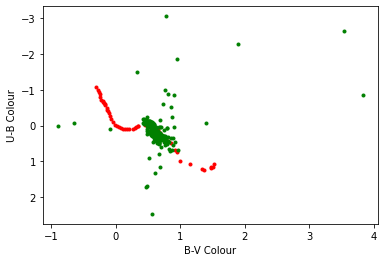

In [616]:
# look at initial plot
fig, ax = plt.subplots()

ax.scatter(ms_tab['B-V'], ms_tab['U-B'], color='red', s=9)
ax.scatter(M52_cut['B-V'], M52_cut['U-B'], color='green', s=9)


# ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('B-V Colour')
ax.set_ylabel('U-B Colour')
print(len(M52_cut))

In [623]:
# Cut outlier stars from M52 table

i = 0 
while i in range(len(M52_cut)-1):
    
    if M52_cut['B-V'][i] < 0.45:
        M52_cut.remove_row(i)
        i+=1
    else:
        i+=1
        continue
k = 0

while k in range(len(M52_cut)-1):
    if M52_cut['B-V'][k] > 0.8:
        M52_cut.remove_row(k)
        k+=1
    else:
        k+=1
        continue

j = 0

while j in range(len(M52_cut)-1):
    if M52_cut['U-B'][j] > 0.8:
        M52_cut.remove_row(j)
        j+=1
    else:
        j+=1
        continue

h = 0
        
while h in range(len(M52_cut)):
    if M52_cut['U-B'][h] < 0.0:
        M52_cut.remove_row(h) 
        h+=1
    else:
        h+=1
        continue

Text(0, 0.5, 'U-B Colour')

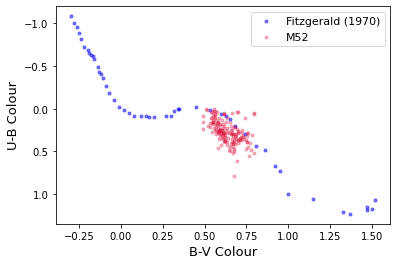

In [624]:
fig, ax = plt.subplots()

ax.scatter(ms_tab['B-V'], ms_tab['U-B'], color='blue', label = 'Fitzgerald (1970)', s=9, alpha =0.5)
ax.scatter(M52_cut['B-V'], M52_cut['U-B'], color='crimson', label= 'M52', s=9, alpha = 0.3)

plt.legend(fontsize=11)


ax.invert_yaxis()
ax.set_xlabel('B-V Colour', fontsize=13)
ax.set_ylabel('U-B Colour', fontsize=13)

In [625]:
# check number of members 
len(M52_cut)

160

160


Text(0.5, 1.0, 'Minimum Chi-square: M52')

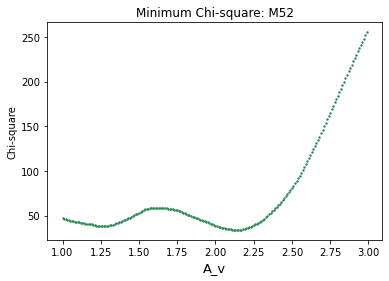

In [626]:
# want to find the closest distance between the curve and star
N_m52 = len(M52_cut)

# set up an array of cluster star xy positions
cluster_pos = np.ones((N_m52, 2))

for i in range(N_m52):
    xy = np.array([M52_cut['B-V'][i], M52_cut['U-B'][i]])
    cluster_pos[i] *= xy

# set up an array of main sequence star xy positions
ms_pos = np.ones((N, 2))

for i in range(N):
    xy = np.array([ms_tab['B-V'][i], ms_tab['U-B'][i]])
    ms_pos[i] *= xy


# loop through A_v values 
A_range = np.arange(1.0, 3.0, 0.01)

# create empty areay for chisquare min values

chisq_true = np.array([])
# create empty array for min distance between all MS stars and all cluster stars
cluster_min = np.ones(N_m52)

for val in A_range:
    A_v = val
    
    # create new empty array for chisq minima
    chisq_mins = np.array([])
    
    # define empty array for new cluster positions
    star_arr = np.ones((N_m52, 2))
    
    for j in range(N_m52):
        
        x = cluster_pos[j][0]
        y = cluster_pos[j][1]
        
        # find shift in star position according to A_v
        dx = A_v / card
        dy = card_ratio * dx 
    
        # new star position
        x_new = x - dx
        y_new = y - dy 

        # add new coords to array
        xy_new = np.array([x_new, y_new])
        star_arr[j] *= xy_new

        # find the length of cluster star to each MS star [x, y]
        r_arr = np.ones((N, 2))

        for k in range(N):
            r = star_arr[j] - ms_pos[k]
            r_arr[k] *= r

        # work out hypotenuse of xy coordinates [r]
        h_arr = np.ones((N))

        for f in range(N):
            h_sq = r_arr[f][0]**2 + r_arr[f][1]**2
            h = h_sq ** (1/2)
            h_arr[f] *= h
        
        # add the minimum distance to array 
        cluster_min[j] *= np.min(h_arr)
        
        # create array for storage of chisquare values
        chisq_arr = np.ones(N)

        # chisquare test for new position
        for q in range(N):
            chisq = (r_arr[q][0]**2)/(M52_cut['B_err'][q]**2+M52_cut['V_err'][q]**2) + (r_arr[q][1]**2)/(M52_cut['U_err'][q]**2+M52_cut['V_err'][q]**2)
            chisq_arr[q] *= chisq
            

        #select minima of chisquare arrays and append to empty array 
        chisq_min = np.min(chisq_arr)
        chisq_mins = np.append(chisq_mins, chisq_min)  
#         print('Chi_min {0}: {1}'.format(A_v, chisq_min))
     
    
    # sum the minima for each star in the cluster at a given A_v value then append to array for plotting
    chisq_sums = np.sum(chisq_mins)
    chisq_true = np.append(chisq_true, chisq_sums)

    # plot MS with new star positions for this A_v value


#     fig, ax = plt.subplots()

#     for pos in star_arr:
#         ax.scatter(pos[0], pos[1], color='crimson', label = 'M52', s=9, alpha=0.3)
#     ax.scatter(ms_tab['B-V'], ms_tab['U-B'], color='blue', label = 'Fitzgerald (1970)', s=9, alpha=0.5)
#     ax.invert_yaxis()
#     ax.set_xlabel('B-V Colour', fontsize=13)
#     ax.set_ylabel('U-B Colour', fontsize=13)
# #     ax.set_xlim(-0.5, 2.0)
# #     ax.set_ylim(2.5, -2)
#     print('A_v: {0}'.format(A_v))

ig, ax = plt.subplots()
ax.scatter(A_range, chisq_true, color = 'seagreen', s=2)
ax.set_xlabel('A_v', fontsize=13)
ax.set_ylabel('Chi-square')
# ax.set_title('Minimum Chi-square: NGC 6939')
ax.set_title('Minimum Chi-square: M52')



[2.15]
37.98495916939157
34.98495916939157


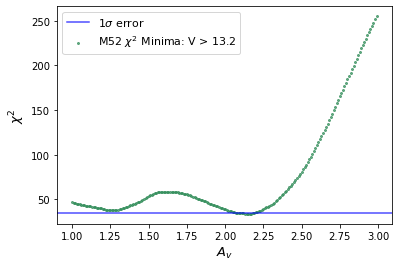

In [630]:
#find exact A_v for minimum chisq
print(A_range[np.where(chisq_true == np.min(chisq_true))])


#determine confidence in A_v to one/two sigma 

one_sig = np.min(chisq_true) + 1
two_sig = np.min(chisq_true) + 4 
print(two_sig)
print(one_sig)


fig, ax = plt.subplots()

ax.scatter(A_range, chisq_true, color = 'seagreen', label= 'M52 $\chi^2$ Minima', s=4, alpha=0.7)
# plt.axhline(y=two_sig, color ='crimson',  label = 'Two sigma', alpha = 0.7)
plt.axhline(y=one_sig, color ='blue', label = '$1\sigma$ error', alpha = 0.7)
ax.set_xlabel('$A_v$', fontsize=13)
ax.set_ylabel('$\chi^2$', fontsize=13)


# ax.set_xlim(1.8, 2.5)
plt.legend(fontsize=11)

